Se tiene que usar Python 3.8 con las siguientes librerias:

In [1]:
import keras
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
print(tf.__version__)
import sklearn
from sklearn.model_selection import train_test_split
from PIL import Image
from keras.preprocessing import image
import os
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import LSTMV1, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Activation
from sklearn.utils.class_weight import compute_class_weight
import random
from tensorflow.keras.preprocessing.image import load_img

2025-05-12 17:33:59.236732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-12 17:33:59.462317: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-05-12 17:33:59.462347: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-05-12 17:33:59.492727: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-12 17:34:00.414800: W tensorflow/stream_executor/platform/de

2.10.0


Aquí se define donde esta el fichero con las imagenes:


In [2]:
from PIL import Image
cur_path = r'/home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/'

In [3]:
data = []
labels = []
classes = 43
 

# Aqui se recuperan las carpetas de entrenamiento
for i in range(classes):
    path = os.path.join(cur_path,'Train',str(i))
    print(f"Verificando: {path}")
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            # Se hace el resize a 30x30
            image = image.resize((30,30))
            image = np.array(image)
            data.append([image,i])
        except:
            print("Error loading image")

Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/0
Error loading image
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/1
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/2
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/3
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/4
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/5
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/6
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-german-traffic-sign/Train/7
Verificando: /home/gab/Downloads/GTSRB---German-Traffic-Sign-Recognition-main/gtsrb-

Se tiene que reordenar las señales para evitar sesgos por orden.

In [4]:
random.shuffle(data)

In [5]:
x = []
y = []

for features,label in data:
    x.append(features)
    y.append(label)

In [6]:
#Converting lists into numpy arrays
x = np.array(x)
y = np.array(y)

El dataset se separa en un 80% de entrenamiento y 20% de validación

In [7]:
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

In [15]:
# Se convierten las imagenes a grayscale
X_train = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_train])
X_val = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X_val])
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_val = X_val / 255.0

error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-15:Bad number of channels) in function 'cv::impl::{anonymous}::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::impl::{anonymous}::Set<3, 4>; VDcn = cv::impl::{anonymous}::Set<1>; VDepth = cv::impl::{anonymous}::Set<0, 2, 5>; cv::impl::{anonymous}::SizePolicy sizePolicy = cv::impl::<unnamed>::NONE; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [9]:
print("Shape of train images is:", X_train.shape)
print("Shape of labels is:", y_train.shape)

strategy = tf.distribute.get_strategy()
print(strategy)

Shape of train images is: (31367, 30, 30, 1)
Shape of labels is: (31367,)


In [10]:
# Se construye el modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(30, 30, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Asignación de pesos a las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    brightness_range=[0.7, 1.2],
    fill_mode="nearest"
)


model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=40,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict
)

model.save('my_model2', save_format='tf')


2025-05-12 17:34:30.078498: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/gab/envs/ai-3.8/lib/python3.8/site-packages/cv2/../../lib64:
2025-05-12 17:34:30.078533: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-05-12 17:34:30.078568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (archlinux): /proc/driver/nvidia/version does not exist
2025-05-12 17:34:30.078924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
980/980 [==============================] - 23s 22ms/step - loss: 3.4300 - accuracy: 0.0751 - val_loss: 2.7433 - val_accuracy: 0.1906
Epoch 2/40
980/980 [==============================] - 21s 21ms/step - loss: 2.2338 - accuracy: 0.2998 - val_loss: 1.5385 - val_accuracy: 0.4949
Epoch 3/40
980/980 [==============================] - 22s 22ms/step - loss: 1.5091 - accuracy: 0.4880 - val_loss: 2.0797 - val_accuracy: 0.3875
Epoch 4/40
980/980 [==============================] - 22s 22ms/step - loss: 1.0909 - accuracy: 0.6115 - val_loss: 0.8426 - val_accuracy: 0.7396
Epoch 5/40
980/980 [==============================] - 22s 22ms/step - loss: 0.8221 - accuracy: 0.6980 - val_loss: 0.4788 - val_accuracy: 0.8340
Epoch 6/40
980/980 [==============================] - 22s 23ms/step - loss: 0.6246 - accuracy: 0.7639 - val_loss: 0.5014 - val_accuracy: 0.8231
Epoch 7/40
980/980 [==============================] - 22s 23ms/step - loss: 0.5083 - accuracy: 0.8074 - val_loss: 0.2293 - val_accuracy:

INFO:tensorflow:Assets written to: my_model2/assets


INFO:tensorflow:Assets written to: my_model2/assets


In [11]:
# Se verifica la validación con el folder de Test de el dataset
from sklearn.metrics import accuracy_score

y_test = pd.read_csv('gtsrb-german-traffic-sign/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

for img in imgs:
    image = Image.open(img).convert('L')
    image = image.resize((30,30))
    data.append(np.array(image))

X_test=np.array(data)
X_test = X_test[..., np.newaxis]
X_test = X_test / 255.0    

pred = np.argmax(model.predict(X_test), axis=-1)

from sklearn.metrics import accuracy_score
print(accuracy_score(labels, pred))

0.9787806809184482


Generación de la matriz de confusión.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.98      1.00      0.99       443
           2       0.99      1.00      0.99       441
           3       0.97      0.99      0.98       287
           4       1.00      0.97      0.98       393
           5       0.99      0.97      0.98       385
           6       1.00      1.00      1.00        81
           7       0.98      1.00      0.99       303
           8       1.00      0.98      0.99       307
           9       1.00      1.00      1.00       281
          10       1.00      1.00      1.00       407
          11       1.00      0.99      0.99       277
          12       1.00      1.00      1.00       407
          13       1.00      1.00      1.00       439
          14       1.00      1.00      1.00       150
          15       1.00      0.99      1.00       129
          16       1.00      1.00      1.00        81
          17       1.00    

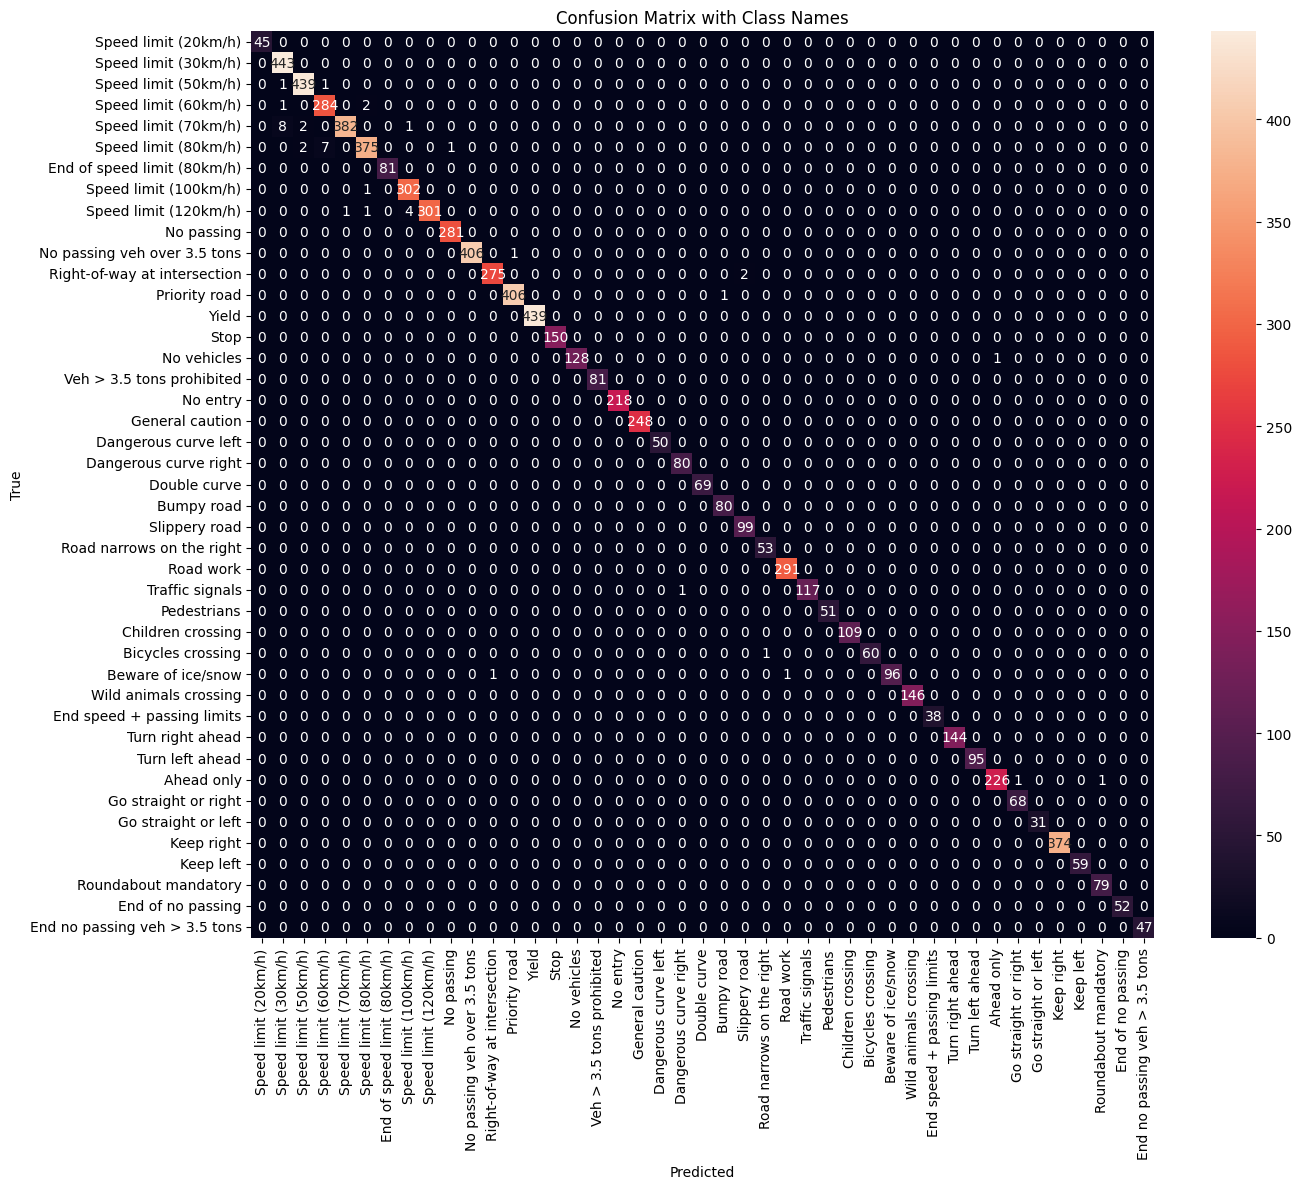

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


y_pred = np.argmax(model.predict(X_val), axis=1)

print(classification_report(y_val, y_pred))
cm = confusion_matrix(y_val, y_pred)

nombres_senales = [
    'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 
    'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
    'Speed limit (120km/h)', 'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection', 
    'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited', 
    'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 
    'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 
    'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 
    'Wild animals crossing', 'End speed + passing limits', 'Turn right ahead', 'Turn left ahead', 
    'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 
    'Roundabout mandatory', 'End of no passing', 'End no passing veh > 3.5 tons'
]


plt.figure(figsize=(14, 12)) 
sns.heatmap(cm, annot=True, fmt='d', xticklabels=nombres_senales, yticklabels=nombres_senales)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix with Class Names')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('after_aug.png')
plt.show()

#### Here we are testing our model on our saved model also we can test on our 15 epoch data result we got.

In [ ]:
# Test with random image
# upload your saved model file
from google.colab import files
files.upload()

In [4]:
import tensorflow
from keras.preprocessing import image  # Import the correct module
from keras.models import load_model
import numpy as np
model = load_model("gtsrb-german-traffic-sign/my_model.h5")

In [5]:
path = r'C:\Users\paula\Desktop\images.jpg'

In [6]:
img = image.load_img(path, target_size = (30,30)) #load the image
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
images = np.vstack([x])

value = classes = np.argmax(model.predict(images,batch_size=32),axis=-1) #predict the label for the image

if classes[0]==0:
    print('Speed limit (20km/h)') #print the content

elif classes[0]==1:
      print('Speed limit (30km/h)') #print the content

elif classes[0]==2:
      print('Speed limit (50km/h)') #print the content

elif classes[0]==3:
      print(' Speed limit (60km/h)') #print the content

elif classes[0]==4:
      print('Speed limit (70km/h)') #print the content

elif classes[0]==5:
      print('Speed limit (80km/h)') #print the content

elif classes[0]==6:
      print('End of speed limit (80km/h)') #print the content

elif classes[0]==7:
      print('Speed limit (100km/h)') #print the content

elif classes[0]==8:
      print('Speed limit (120km/h)') #print the content

elif classes[0]==9:
      print('No passing') #print the content
        
elif classes[0]==10:
      print('No passing veh over 3.5 tons') #print the content 
        
elif classes[0]==11:
      print(', Right-of-way at intersection') #print the content
        
elif classes[0]==12:
      print('Priority road') #print the content
        
elif classes[0]==13:
      print('Yield') #print the content       
        
elif classes[0]==14:
      print('Stop') #print the content       
        
elif classes[0]==15:
      print('No vehicles') #print the content
                
elif classes[0]==16:
      print('Veh > 3.5 tons prohibited') #print the content       
        
elif classes[0]==17:
      print('No entry') #print the content        
                       
elif classes[0]==18:
      print('General caution') #print the content       
                
elif classes[0]==19:
      print('Dangerous curve left') #print the content        
        
elif classes[0]==20:
      print('Dangerous curve right') #print the content        
        
elif classes[0]==21:
      print('Double curve') #print the content       
        
elif classes[0]==22:
      print('Bumpy road') #print the content        
                
elif classes[0]==23:
      print('Slippery road') #print the content        
        
elif classes[0]==24:
      print('Road narrows on the right') #print the content               
        
elif classes[0]==25:
      print('Road work') #print the content        
        
elif classes[0]==26:
      print('Traffic signals') #print the content
        
elif classes[0]==27:
      print('Pedestrians') #print the content       
                
elif classes[0]==28:
      print('Children crossing') #print the content
        
elif classes[0]==29:
      print( 'Bicycles crossing') #print the content
               
elif classes[0]==30:
      print('Beware of ice/snow') #print the content        
        
elif classes[0]==31:
      print('Wild animals crossing') #print the content        
               
elif classes[0]==32:
      print('End speed + passing limits') #print the content        
        
elif classes[0]==33:
      print('Turn right ahead') #print the content
        
elif classes[0]==34:
      print('Turn left ahead') #print the content        
        
elif classes[0]==35:
      print('Ahead only') #print the content        
        
elif classes[0]==36:
      print('Go straight or right') #print the content
        
elif classes[0]==37:
      print('Go straight or left') #print the content        
        
elif classes[0]==38:
      print('Keep right') #print the content
        
elif classes[0]==39:
      print('Keep left') #print the content       
        
elif classes[0]==40:
      print('Roundabout mandatory') #print the content

elif classes[0]==41:
      print('End of no passing') #print the content        
        
else:
      print('End no passing veh > 3.5 tons') #print the content

1/1 [==============================] - 0s 195ms/step
Stop


In [ ]:
#Para entrenar el modelo con las 44 clases solo es necesario modificar: 
data = []
labels = []
classes = 44
 

# Aqui se recuperan las carpetas de entrenamiento
for i in range(classes):
    path = os.path.join(cur_path,'Train',str(i))
    print(f"Verificando: {path}")
    images = os.listdir(path)

    for a in images:
        try:
            image = Image.open(os.path.join(path, a))
            # Se hace el resize a 30x30
            image = image.resize((30,30))
            image = np.array(image)
            data.append([image,i])
        except:
            print("Error loading image")

#Ejecutar los pasos siguientes hasta llegar a la construcción del modelo

In [ ]:
# Se construye el modelo con las 44 clases
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(30, 30, 1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(44, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Asignación de pesos a las clases
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = dict(enumerate(class_weights))

aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    brightness_range=[0.7, 1.2],
    fill_mode="nearest"
)


model.fit(
    aug.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=40,
    validation_data=(X_val, y_val),
    class_weight=class_weights_dict
)

model.save('my_model2', save_format='tf')